In [1]:
import mindspore
from mindspore import load_checkpoint, load_param_into_net,Tensor
import numpy as np
from models import SciNet
from utils import pendulum
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
# Load trained model
scinet = SciNet(50,1,3,64)
param_dict = load_checkpoint("trained_models/scinet1.ckpt")
load_param_into_net(scinet, param_dict)

([], [])

In [3]:
# Set resolution for plots
size = 20

# Initialize array for latent layer information
neuron_activation = [np.zeros((size,size)),np.zeros((size,size)),np.zeros((size,size))]

# Set pendulum parameters
tmax = 10
A0 = 1
delta0 = 0
m = 1
N_SAMPLE = 50
for ik, k in enumerate(np.linspace(5,10,size)):
    for ib, b in enumerate(np.linspace(0.5,1,size)):

        tprime = np.random.uniform(0,tmax)
        question = tprime
        answer = pendulum(tprime,A0,delta0,k,b,m)
        if answer == None:
            continue
        x = np.linspace(0,tmax,50)
        t_arr = np.linspace(0,tmax,N_SAMPLE)
        x = pendulum(t_arr,A0,delta0,k,b,m)
        combined_inputs = np.append(x, question)
        results = scinet(Tensor([combined_inputs]))

        latent_layer = scinet.mu.numpy()[0]
        
        neuron_activation[0][ik,ib] = latent_layer[0]
        neuron_activation[1][ik,ib] = latent_layer[1]
        neuron_activation[2][ik,ib] = latent_layer[2]


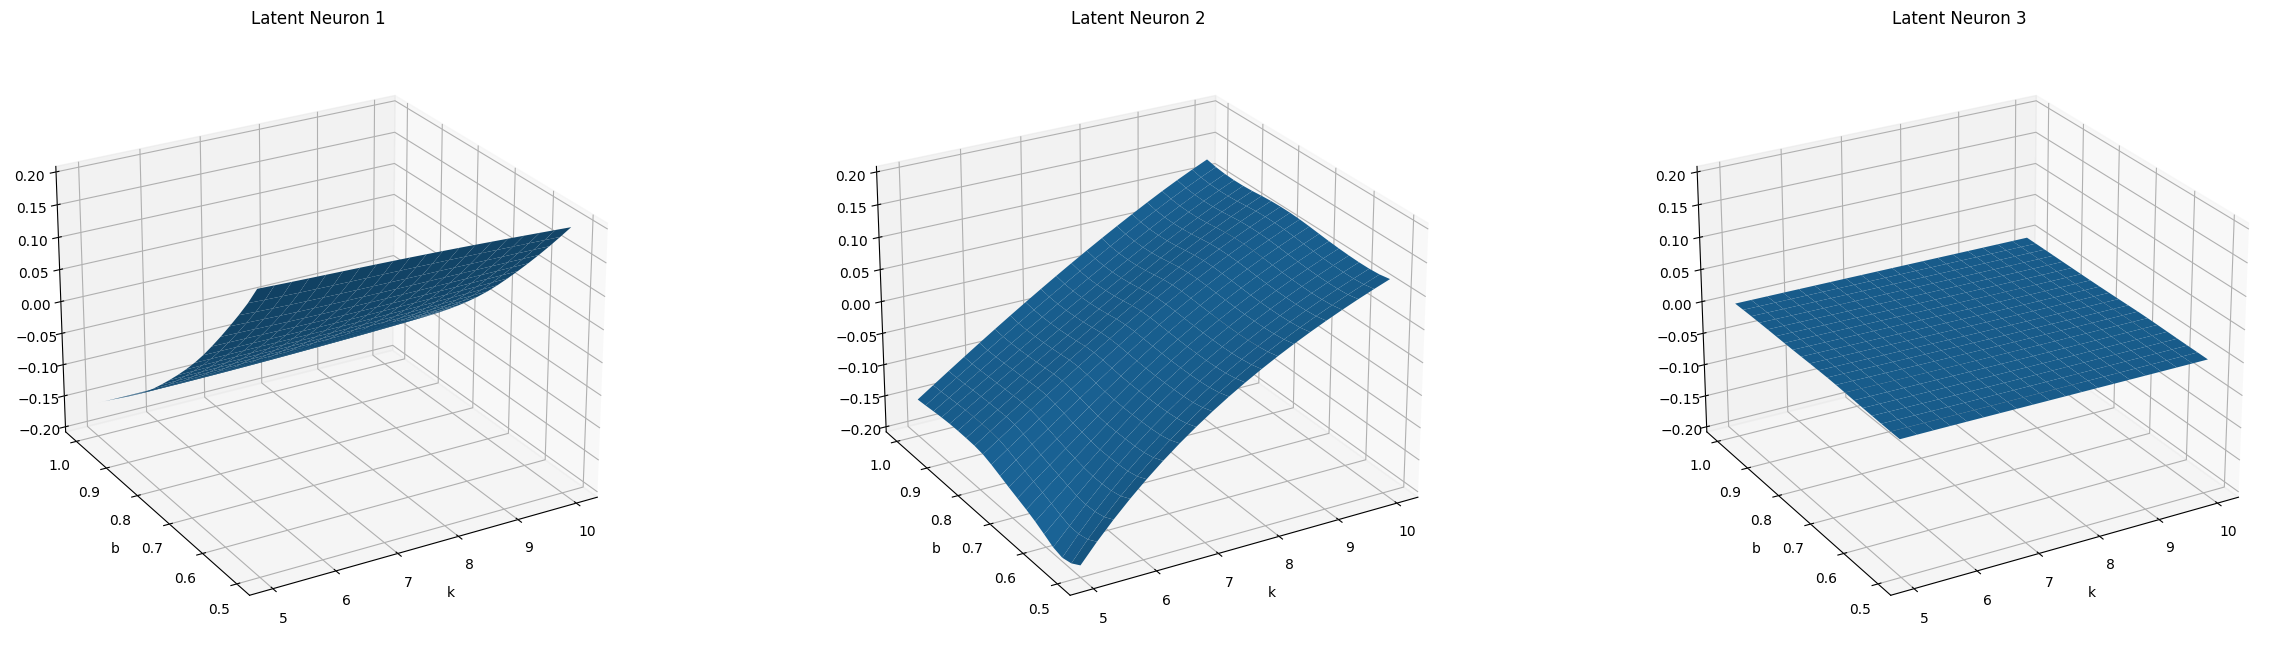

In [4]:
fig = fig = plt.figure(figsize=(30,8))
for i in range(3):
    ax = fig.add_subplot(1, 3, 1+i, projection='3d')
    k_array = np.linspace(5,10,size)
    b_array = np.linspace(0.5,1,size)
    X,Y = np.meshgrid(k_array, b_array)
    Z = neuron_activation[i]
    surf = ax.plot_surface(X, Y, Z, cmap=None,
                           linewidth=0, antialiased=True)
    ax.set_xlabel("k")
    ax.set_ylabel("b")
    ax.set_zlim3d(-.2,.2)
    ax.set_title("Latent Neuron %i" % (i+1))
    ax.view_init(25, -120)


plt.show()

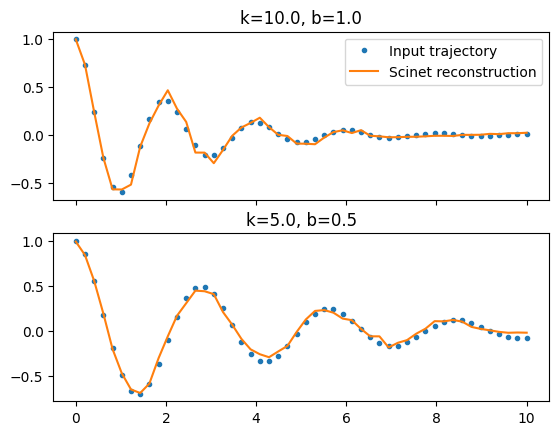

In [5]:
from utils import pendulum as solution
# Pendulum settings
tmax = 10
A0 = 1
delta0 = 0
m = 1
N_SAMPLE = 50

xarr = np.linspace(0,tmax,N_SAMPLE)
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

yarr = solution(xarr,A0,delta0,10,1,m)
sampled_points = yarr
y_test = []
xspace = np.linspace(0,tmax,50)

for x in xspace:
    x_in = np.append(sampled_points, x)
    x_in = Tensor(x_in).reshape(1,N_SAMPLE+1)
    x_in = x_in.astype(mindspore.float32)
    pred  = scinet(x_in)
    y_test.append(pred[0,0])
ax1.plot(xspace,yarr, ".", label="Input trajectory")
ax1.plot(xspace,y_test, label="Scinet reconstruction")
ax1.legend(loc="upper right")
ax1.set_title("k=%.1f, b=%.1f" %(10,1))

yarr = solution(xarr,A0,delta0,5,0.5,m)
sampled_points = yarr
y_test = []
xspace = np.linspace(0,tmax,50)

for x in xspace:
    x_in = np.append(sampled_points, x)
    x_in = Tensor(x_in).reshape(1,N_SAMPLE+1)
    x_in = x_in.astype(mindspore.float32)
    y_test.append(scinet(x_in)[0,0])
ax2.plot(xspace,yarr, ".", label="Input trajectory")
ax2.plot(xspace,y_test, label="Scinet reconstruction")
ax2.set_title("k=%.1f, b=%.1f" %(5,0.5))
plt.show()